In [527]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from difflib import get_close_matches
from IPython.display import display
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import seaborn as sns
import statistics

## Preprocessing & data cleaning

**steps include:**
- renaming dataset columns to snake_case and english
- checking for missing values
- checking for potential outliers
- adding column country 
- validating text data
- converting date to integer

In [528]:
df = pd.read_csv("fotbal_prestupy_2000_2019.csv", encoding='utf-8')

In [529]:
df.head()

,Jméno,Pozice,Věk,Původní tým,Původní liga,Nový tým,Nová Liga,Sezóna,Odhadovaná hodnota,Přestupová částka
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


In [530]:
df.rename(columns={"Jméno": "name", 
                   "Pozice": "position", 
                   "Věk": "age", 
                   "Původní tým": "original_team", 
                   "Původní liga": "original_league",
                   "Nový tým": "new_team",
                   "Nová  Liga": "new_league",
                   "Sezóna": "season",
                   "Odhadovaná hodnota": "estimated_value",
                   "Přestupová částka": "transfer_fee"}, inplace=True)
df.head()

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
0,Luís Figo,Right Winger,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000-2001,NaN,60000000
1,Hernán Crespo,Centre-Forward,25,Parma,Serie A,Lazio,Serie A,2000-2001,NaN,56810000
2,Marc Overmars,Left Winger,27,Arsenal,Premier League,FC Barcelona,LaLiga,2000-2001,NaN,40000000
3,Gabriel Batistuta,Centre-Forward,31,Fiorentina,Serie A,AS Roma,Serie A,2000-2001,NaN,36150000
4,Nicolas Anelka,Centre-Forward,21,Real Madrid,LaLiga,Paris SG,Ligue 1,2000-2001,NaN,34500000


## Understanding the dataset

From limited information about the data, some research had to be done to understand and correctly interpret data. Based on empirical evidence, transfer_fee and estimated_value are both in €. For the sake of readability, I will divide those columns by 1000, making it estimated and true value of the player in thousands of euros. 

In [531]:
df["transfer_fee"] = df["transfer_fee"]/1000
df["estimated_value"] = df["estimated_value"]/1000

### Validating text columns 
First I want to check all the text columns and try to find possible typos which could lead to duplicities. For this I will use difflib function get_close_matches, which will be able to return similar enough cases and should cover typos and mistranslations. 

In [532]:
text_cols = ["name", "position", "original_team", "original_league", "new_team", "new_league"]

def preprocess_text(column):
    column = column.str.strip() # strip trailing spaces 
    column = column.str.replace("-"," ") # replace - with space
    column = column.str.replace("\n","") # remove newlines
    column = column.str.replace("\t","") # remove tabs
    column = column.str.lower() # all lowercase
    return column

In [533]:
for col in text_cols:
    df[col] = preprocess_text(df[col])

In [534]:
def get_similar_entities(unique_names):
    matches= []
    for i, name in enumerate(list(unique_names)):
        possible_match = get_close_matches(name, list(unique_names[i+1:]), cutoff=0.7)
        if possible_match:
            matches.append((name, possible_match))
    return matches

In [535]:
for col in ["team", "league"]:
    display(f"Similarities for {col}s:")
    display(get_similar_entities(pd.concat([df[f"original_{col}"], df[f"new_{col}"]]).unique()))

'Similarities for teams:'

[('fc barcelona', ['fc barcelona b', 'barcelona sc', 'fc basel']),
 ('parma', ['paraná']),
 ('arsenal', ['arsenal fc', 'arsenal u23', 'arsenal u18']),
 ('real madrid', ['real murcia']),
 ('west ham', ['west brom']),
 ('monaco', ['monza']),
 ('valencia cf', ['valencia b']),
 ('atlético madrid', ['atlético pr', 'atlético mg']),
 ('atlético pr', ['atlético mg']),
 ('chelsea', ['chelsea u23']),
 ('inter', ['inter u19']),
 ('benfica', ['benfica b', 'benfica u19']),
 ('sparta praha', ['sparta r.']),
 ('partizan', ['paraná']),
 ('sporting cp', ['sporting gijón']),
 ('são paulo', ['fc são paulo b']),
 ('racing', ['reading', 'racing club']),
 ('lens', ['león', 'le mans']),
 ('mk dons', ['mk dons u18']),
 ('internacional', ['nacional', 'ternana']),
 ('dinamo zagreb', ['nk zagreb', 'dinamo bukarest']),
 ('olympiacos', ['olimpia']),
 ('bolton', ['bologna']),
 ('juventus', ['juventude']),
 ('rangers', ['sco angers']),
 ('nacional', ['atl. nacional']),
 ('loko moscow', ['cska moscow', 'torpedo mosco

'Similarities for leagues:'

[('laliga', ['laliga2']),
 ('serie a', ['série a', 'serie b', 'serie c   a']),
 ('premier league', ['u18 premier league', 'super league', 'premier liga']),
 ('ligue 1', ['ligue 2', 'liga 1', 'rel. ligue 1']),
 ('serie b', ['série b', 'serie c   b', 'série a']),
 ('1.bundesliga', ['2.bundesliga', 'bundesliga']),
 ('liga nos', ['liga 1']),
 ('eredivisie', ['u19 eredivisie']),
 ('england', ['finland']),
 ('süper lig', ['superliga', 'superligaen']),
 ('croatia', ['romania']),
 ('super league',
  ['stars league', 'u18 premier league', 'jupiler pro league']),
 ('2.bundesliga', ['bundesliga']),
 ('1.lig', ['3.liga']),
 ('k league 1', ['j2 league', 'j1 league', 'league one']),
 ('serie c   a', ['serie c   b']),
 ('série a', ['série b']),
 ('superligaen', ['superliga']),
 ('j1 league', ['j2 league']),
 ('torneo final', ['torneo inicial']),
 ('2ª b   grupo iii', ['2ª b   grupo i']),
 ('liga mx clausura', ['liga mx apertura']),
 ('liga 1   championship group',
  ['a grupa   championship gr.', 'su

### Text cols revision results:
**Revision of close matches found out two mistakes:**
Al Shabab was in several instances named just Shabab
Al Nasr was in several instances named just Nasr

In [536]:
df.loc[df["original_team"] == "shabab", "original_team"] = "al shabab"
df.loc[df["new_team"] == "shabab", "original_team"] = "al shabab"

df.loc[df["original_team"] == "nasr", "original_team"] = "al nasr"
df.loc[df["new_team"] == "nasr", "new_team"] = "al nasr"

## Validating other columns 
looking into season, age, estimated_value and transfer_fee columns

In [537]:
df["season"] = df["season"].str.split("-", expand=True)[0] # take the starting year of season
df["season"] = df["season"].astype(int)

### Check validity of ages 

In [538]:
df["age"].sort_values(ascending=True) # There is one player who is 0 years old

236      0
1370    15
945     16
4502    16
1306    16
        ..
439     34
112     35
2954    35
487     35
2414    35
Name: age, Length: 4700, dtype: int64

There is one player with age 0. Assuming his parents did not sell his soul to a Saudi Arabian football club, I will impute this value with information available online. If there were more cases than just 1 and imputing with real data was too time consuming or impossible, I would use mean or median imputation. 

From his wikipedia page, I can see that he was 25 years old during his transfer from al shabab to ittihad

In [539]:
df[df["age"] == 0]

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
236,marzouq al otaibi,centre forward,0,al shabab,saudi arabia,ittihad,saudi arabia,2000,NaN,2000.0


In [540]:
df.loc[df["age"] == 0, "age"] = 25

In [541]:
df["age"].isna().sum() 

0

### Check validity of season
The number and values of seasons matches. No validation to go through here.

In [542]:
df["season"].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

### Check validity of transfer_fee


In [543]:
df["transfer_fee"].isna().sum() # no missing values

0

In [544]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,age,season,estimated_value,transfer_fee
count,4700.00,4700.00,3440.00,4700.00
mean,24.34,2009.00,8622.47,9447.59
std,3.21,5.47,8795.18,10437.72
min,15.00,2000.00,50.00,825.00
25%,22.00,2004.00,3500.00,4000.00
50%,24.00,2009.00,6000.00,6500.00
75%,27.00,2014.00,10000.00,10820.00
max,35.00,2018.00,120000.00,222000.00


### Check validity of estimated_value

In [545]:
df[df.isna().any(axis=1)] #1260 missing values -> all of them are in estimated_value 

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
0,luís figo,right winger,27,fc barcelona,laliga,real madrid,laliga,2000,NaN,60000.0
1,hernán crespo,centre forward,25,parma,serie a,lazio,serie a,2000,NaN,56810.0
2,marc overmars,left winger,27,arsenal,premier league,fc barcelona,laliga,2000,NaN,40000.0
3,gabriel batistuta,centre forward,31,fiorentina,serie a,as roma,serie a,2000,NaN,36150.0
4,nicolas anelka,centre forward,21,real madrid,laliga,paris sg,ligue 1,2000,NaN,34500.0
...,...,...,...,...,...,...,...,...,...,...
4355,douglas luiz,central midfield,19,vasco da gama,série a,man city,premier league,2017,NaN,12000.0
4427,jadon sancho,left winger,17,man city u18,u18 premier league,bor. dortmund,1.bundesliga,2017,NaN,7840.0
4618,davide bettella,centre back,18,inter,serie a,atalanta,serie a,2018,NaN,7000.0
4648,william bianda,centre back,18,lens,ligue 2,as roma,serie a,2018,NaN,6000.0


There are missing values across all the years except 2015. 
Most of  them in 2000, 2001, 2002, 2003, 2004.

Possible solutions: 
   - Dropping the values
   - mean/median imputation 
   - regression imputation

In [546]:
df[df.isna().any(axis=1)]["season"].value_counts() 

season
2001    250
2000    248
2002    244
2003    242
2004    189
2005     28
2006     20
2007     13
2008      7
2010      4
2017      3
2018      3
2012      2
2013      2
2009      2
2014      1
2016      1
2011      1
Name: count, dtype: int64

### Outliers 
Checking for outliers is useful, as their presence could negatively affect models/statistical analysis etc. 
However due to this being only EDA task, while identifying and storing outliers, I will not remove them nor take any measures. On the contrary, I find them quite interesting to look at -> they could give us more insight into why these players are so expensive.
The main idea being not removing outliers from this dataset is that it is NOT randomly sampled - we are sampling the 250 most expensive football transfers in the year, it is natural that we get some extreme values that  all others. 

In [547]:
def get_outliers_iqr(df, column_name):
    sns.set_palette("turbo")
    fig, ax = plt.subplots(figsize=(10, 6))
    boxplot = ax.boxplot(df[column_name], vert=False, patch_artist=True)

    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    lower_bound_ex = q1 - 3 * iqr
    upper_bound_ex = q3 + 3 * iqr

    outliers = df[((df[column_name] < lower_bound) & (df[column_name] >= lower_bound_ex)) | (
            (df[column_name] > upper_bound) & (df[column_name] <= upper_bound_ex))]
    ext_outliers = df[(df[column_name] < lower_bound_ex) | (df[column_name] > upper_bound_ex)]

    ax.scatter(outliers[column_name], [1] * len(outliers),  alpha=0.7, label='Outliers', s=15, marker='o')
    ax.scatter(ext_outliers[column_name], [1] * len(ext_outliers), alpha=0.7, label='Extreme Outliers', s=20, marker='x')

    ax.axvline(lower_bound_ex, color='orange', linestyle='--', label='Lower Bound (3*IQR)')
    ax.axvline(upper_bound_ex, color='orange', linestyle='--', label='Upper Bound (3*IQR)')

    ax.set_yticklabels([column_name])
    ax.set_xlabel('Values')
    ax.set_title(f'Boxplot for {column_name} with Outliers')

    ax.legend()

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.show()
    return outliers, ext_outliers
    

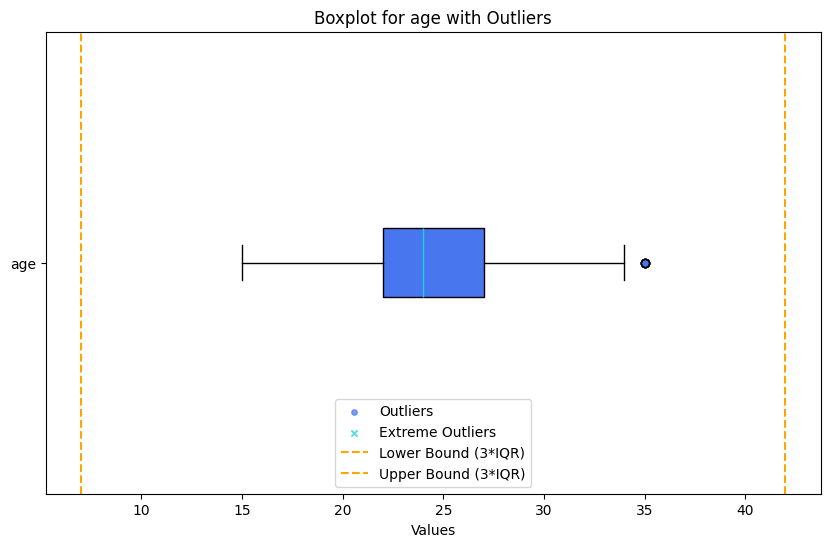

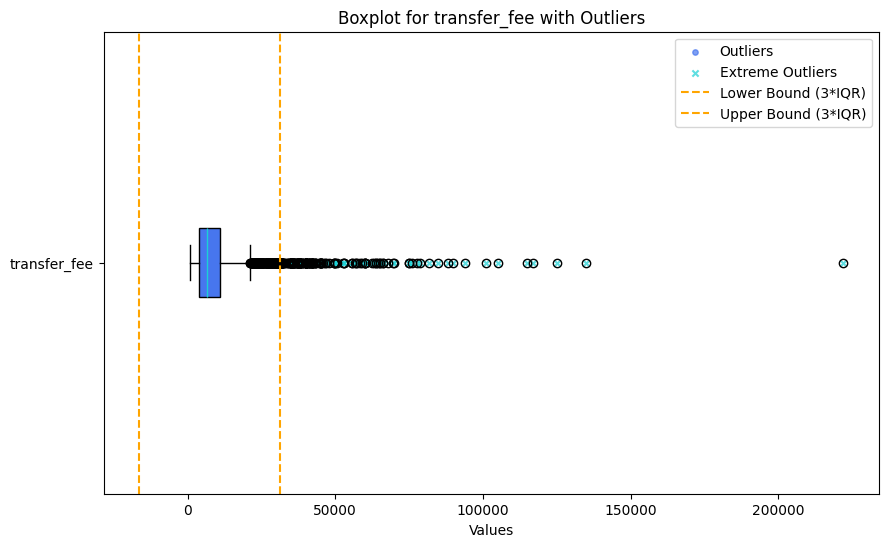

In [548]:
get_outliers_iqr(df, "age")
outliers, ext_outliers = get_outliers_iqr(df, "transfer_fee")

In [549]:
ext_outliers.sort_values(by=["transfer_fee"], ascending=False)

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee
4211,neymar,left winger,25,fc barcelona,laliga,paris sg,ligue 1,2017,100000.0,222000.0
4455,kylian mbappé,right winger,19,monaco,ligue 1,paris sg,ligue 1,2018,120000.0,135000.0
4212,philippe coutinho,attacking midfield,25,liverpool,premier league,fc barcelona,laliga,2017,90000.0,125000.0
4456,cristiano ronaldo,centre forward,33,real madrid,laliga,juventus,serie a,2018,100000.0,117000.0
4213,ousmane dembélé,right winger,20,bor. dortmund,1.bundesliga,fc barcelona,laliga,2017,33000.0,115000.0
...,...,...,...,...,...,...,...,...,...,...
2976,oscar,attacking midfield,20,internacional,série a,chelsea,premier league,2012,20000.0,32000.0
3730,danilo,right back,23,fc porto,liga nos,real madrid,laliga,2015,25000.0,31500.0
1233,shaun wright phillips,right winger,23,man city,premier league,chelsea,premier league,2005,9500.0,31500.0
1730,anderson,central midfield,19,fc porto,liga nos,man utd,premier league,2007,25000.0,31500.0


### Imputing missing values

For handling missing values I decided to go with regression imputation. Imputing with mean or median values for estimated_value column would make little to no sense as there clearly is a correlation between the *estimated_value* and *transfer_fee* and we should account for that. I decided to go with a simple model with only one explanatory variable and that being *transfer_fee*. Other values such as the player position could be added for more complex model. Needless to say, with R^2 ~ 0.73, the model does a sufficiently good job at imputing the missing values.

R-squared (R2): 0.7295
Mean Squared Error (MSE): 19787873.6186
Root Mean Squared Error (RMSE): 4448.3563


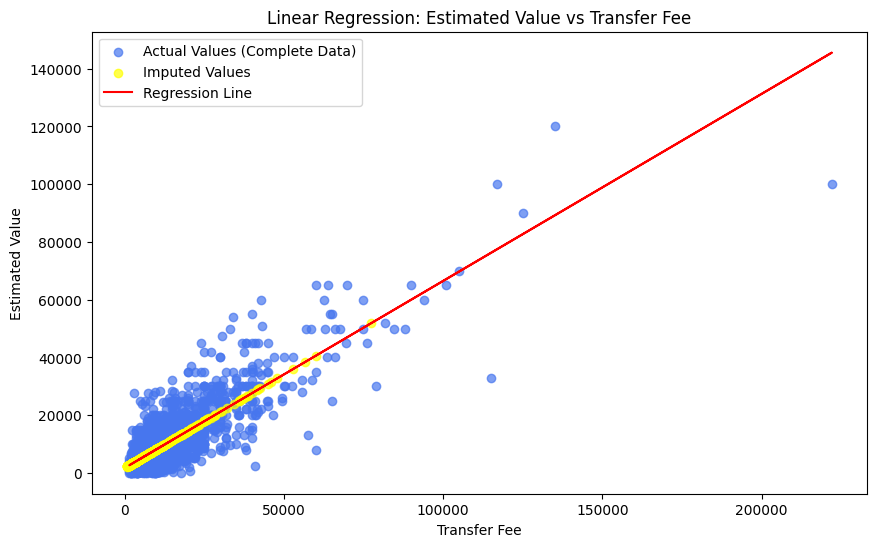

In [550]:
df_copy = pd.get_dummies(df, columns=['position'])
df_complete = df_copy.dropna(subset=['estimated_value'])
df_incomplete = df_copy[df_copy['estimated_value'].isnull()]

X_cols = ['transfer_fee']

X = df_complete[X_cols]
y = df_complete['estimated_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
sns.set_palette("turbo")

plt.figure(figsize=(10, 6))

plt.scatter(df_complete['transfer_fee'], y, alpha=0.7, label='Actual Values (Complete Data)')
plt.scatter(df_incomplete['transfer_fee'], model.predict(df_incomplete[X_cols]), color = 'yellow', alpha=0.7, label='Imputed Values')
plt.plot(df_complete['transfer_fee'], model.predict(X), color='red', label='Regression Line')

plt.title('Linear Regression: Estimated Value vs Transfer Fee')
plt.xlabel('Transfer Fee')
plt.ylabel('Estimated Value')
plt.legend()
plt.show()
df.loc[df['estimated_value'].isnull(), 'estimated_value'] = model.predict(df_incomplete[X_cols])

### Deriving feature country - this is me trying to be original
**While league and team may be useful identificators of the background, it may not always be clear where the team is from as we have 615 unique teams. I decided to engineer a features "origin_country" and "target_country", that will represent the countries of the original and target teams, respectively.**

**For this I decided to use GPT 3.5 from OpenAI with the prompt:**
*"You will be presented with a list of football teams. I want you to assign the country of origin to them. Provide me with an output in the form of a python dictionary. E.g. {"Chelsea": "England", "Bayern": "Germany"}. If you are not sure what country the team is from, type "unknown"."*


**Outputs from the language model were saved into *countries.json* file.** 

In [551]:
pd.concat([df["original_team"], df["new_team"]]).unique()  # output from this list was used in the prompt to generate the feature country

array(['fc barcelona', 'parma', 'arsenal', 'fiorentina', 'real madrid',
       'west ham', 'dep. la coruña', 'real zaragoza', 'monaco',
       'valencia cf', 'atlético madrid', 'atlético pr', 'river plate',
       'boca juniors', 'stade rennais', 'coventry city',
       'cagliari calcio', 'bay. leverkusen', 'chelsea', 'dynamo kyiv',
       'inter', 'rcd mallorca', 'g. bordeaux', 'fc porto', 'benfica',
       'lazio', 'real betis', 'everton', 'sparta praha', 'málaga cf',
       'partizan', 'celta de vigo', 'sporting cp', 'aston villa',
       'afc ajax', 'são paulo', 'marseille', 'racing', 'lens', 'mk dons',
       'cd tenerife', 'norwich', 'celtic', 'fenerbahce', 'middlesbrough',
       'internacional', 'leicester', 'rosenborg bk', 'dinamo zagreb',
       'feyenoord', 'grasshoppers', 'olympiacos', 'bolton', 'reggina',
       'juventus', 'fluminense', 'lecce', 'liverpool', 'cd cruz azul',
       'u. de chile', 'ponte preta', 'vitesse', 'galatasaray',
       'montpellier', 'roda jc', 're

In [552]:
with open("countries.json", "r", encoding="utf-8") as f:
    countries = json.load(f)

In [553]:
df_countries = pd.DataFrame.from_dict(countries.items())
df_countries.columns =["team", "country"]
df_countries["team"] = preprocess_text(df_countries["team"])
df_countries["country"] = preprocess_text(df_countries["country"])

In [554]:
df = pd.merge(df, df_countries, left_on=['new_team'], right_on=['team'], how='left')
df = pd.merge(df, df_countries, left_on=['original_team'], right_on=['team'], how='left', suffixes=('_new', '_original'))
df.drop(['team_new', 'team_original'], axis=1, inplace=True)
df.rename(columns={'country_new': 'new_country', 'country_original': 'original_country'}, inplace=True)

In [555]:
df.head()

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee,new_country,original_country
0,luís figo,right winger,27,fc barcelona,laliga,real madrid,laliga,2000,40548.386775,60000.0,spain,spain
1,hernán crespo,centre forward,25,parma,serie a,lazio,serie a,2000,38481.020417,56810.0,italy,italy
2,marc overmars,left winger,27,arsenal,premier league,fc barcelona,laliga,2000,27586.842210,40000.0,spain,england
3,gabriel batistuta,centre forward,31,fiorentina,serie a,as roma,serie a,2000,25091.744882,36150.0,italy,italy
4,nicolas anelka,centre forward,21,real madrid,laliga,paris sg,ligue 1,2000,24022.417455,34500.0,france,spain


# Analysis of the dataset
## 1. Basic analysis
First we should take a closer look at some basic statistical facts in the dataset. This will help us possibly derive more information as we move forward. We already know some basic info about outlying values and missing values. 

This will include
- distribution of transfer fees
- distribution of age  

In [585]:
def get_hist(df,col,msg=""):
    sns.set_palette("turbo")
    plt.hist(df[col], bins=20, edgecolor="black")
    plt.title(f"Distribution of values in {col} {msg}:")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    
    print(f"Mean value of '{col}' {msg}: {np.mean(df[col])}")
    print(f"Median value of '{col}' {msg}: {np.median(df[col])}")
    print(f"Variance value of '{col}' {msg}: {np.var(df[col])}")
    print(f"1st quartile value of '{col}' {msg}: {df[col].quantile(0.25)}")
    print(f"3rd quartile value of '{col}' {msg}: {df[col].quantile(0.75)}")

def get_relative_freq_categorical(df, col):
    position_counts = df[col].value_counts(normalize=True, sort=True)

    sns.set_palette("turbo")

    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    bar_plot = sns.barplot(x=position_counts.index, y=position_counts.values)

    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.title(f'Relative Frequencies of {col}')

    # plt.xticks(rotation=45, ha='right')
    plt.xticks(rotation=90)

    for p in bar_plot.patches:
        bar_plot.annotate(f'{p.get_height()*100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                          ha='center', va='center', xytext=(0, 25), textcoords='offset points', rotation = 90)

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_popular_destinations(dest, top_n):
    country_counts = df.groupby(['season', dest]).size().reset_index(name='counts')
    season_totals = country_counts.groupby('season')['counts'].sum().reset_index(name='total_appearances')

    country_counts = pd.merge(country_counts, season_totals, on='season', how='left')
    country_counts['proportion'] = country_counts['counts'] / country_counts['total_appearances']

    top_countries = country_counts.groupby(dest)['proportion'].sum().nlargest(top_n).index

    top_countries_data = country_counts[country_counts[dest].isin(top_countries)]

    pivot_data = top_countries_data.pivot(index='season', columns=dest, values='proportion').fillna(0)

    plt.figure(figsize=(10, 6))
    for country in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[country], label=country, marker='o')

    plt.title(f'Top {top_n} Most Frequent {dest} (Proportional) Over the Years')
    plt.xlabel('Season')
    plt.ylabel('Proportion of Appearances')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(pivot_data.index[pivot_data.index % 1 == 0].astype(int))

    plt.grid(True)
    plt.show()

def median_price_per_player(df, col):
    sorted_positions = df.groupby(col)['transfer_fee'].median().sort_values(ascending=False).index

    # Create a boxplot using seaborn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='transfer_fee', data=df, order=sorted_positions)
    sns.set_palette("turbo")

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.title(f'Transfer Fees by ')
    plt.xlabel(col)
    plt.ylabel('Transfer Fee (in thousands of €)')
    
    # Display mean, median, and support values in a separate DataFrame
    summary_df = pd.DataFrame({
        'Position': sorted_positions,
        'Median': df.groupby(col)['transfer_fee'].median().loc[sorted_positions],
        'Mean': df.groupby(col)['transfer_fee'].mean().loc[sorted_positions].round(2),
        'Support': df[col].value_counts().loc[sorted_positions]
    })
    
    # Print the summary DataFrame
    print("Summary DataFrame:")
    print(summary_df)

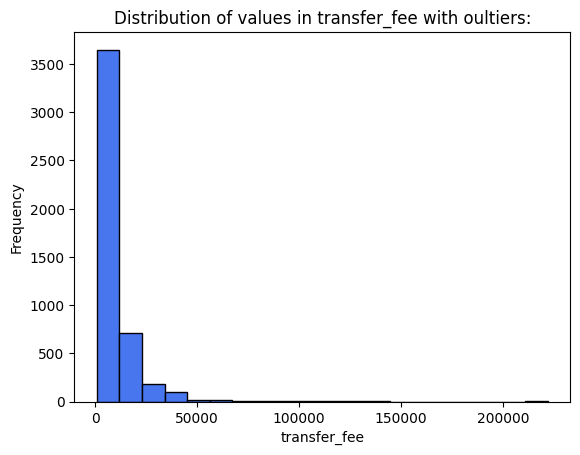

Mean value of 'transfer_fee' with oultiers: 9447.586170212766
Median value of 'transfer_fee' with oultiers: 6500.0
Variance value of 'transfer_fee' with oultiers: 108922804.64683002
1st quartile value of 'transfer_fee' with oultiers: 4000.0
3rd quartile value of 'transfer_fee' with oultiers: 10820.0


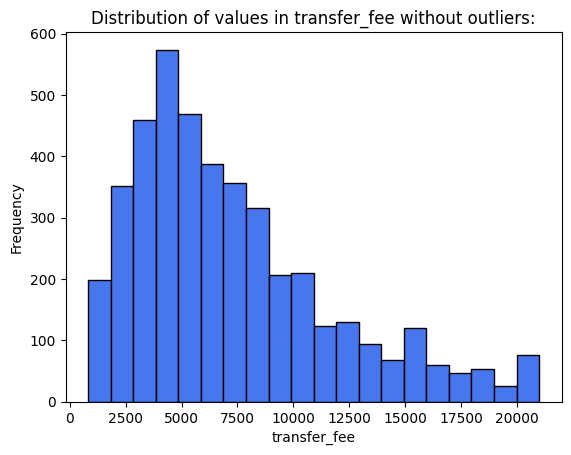

Mean value of 'transfer_fee' without outliers: 7136.066389081656
Median value of 'transfer_fee' without outliers: 6000.0
Variance value of 'transfer_fee' without outliers: 19499766.651387077
1st quartile value of 'transfer_fee' without outliers: 4000.0
3rd quartile value of 'transfer_fee' without outliers: 9200.0


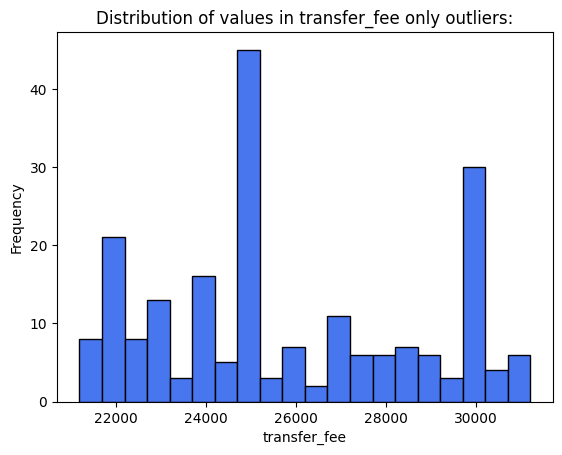

Mean value of 'transfer_fee' only outliers: 25810.428571428572
Median value of 'transfer_fee' only outliers: 25000.0
Variance value of 'transfer_fee' only outliers: 8347978.387755101
1st quartile value of 'transfer_fee' only outliers: 23515.0
3rd quartile value of 'transfer_fee' only outliers: 28475.0


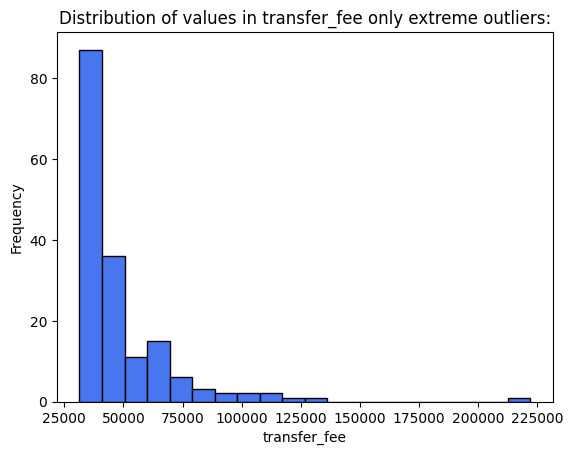

Mean value of 'transfer_fee' only extreme outliers: 48708.08383233533
Median value of 'transfer_fee' only extreme outliers: 40000.0
Variance value of 'transfer_fee' only extreme outliers: 533836934.05285245
1st quartile value of 'transfer_fee' only extreme outliers: 36075.0
3rd quartile value of 'transfer_fee' only extreme outliers: 52790.0


In [557]:
get_hist(df,"transfer_fee", "with oultiers")
df_without_outliers = df[~df.isin(pd.concat([outliers, ext_outliers]))].dropna()
get_hist(df_without_outliers,"transfer_fee", "without outliers")
get_hist(outliers,"transfer_fee" ,"only outliers")
get_hist(ext_outliers,"transfer_fee" ,"only extreme outliers")

Distribution of age approx. normally distributed with mean= 24.34 and var = 10.3. 
With IQR being 22 - 27, we can say that 50 % of the most expensive players are between 22 - 27 years old.

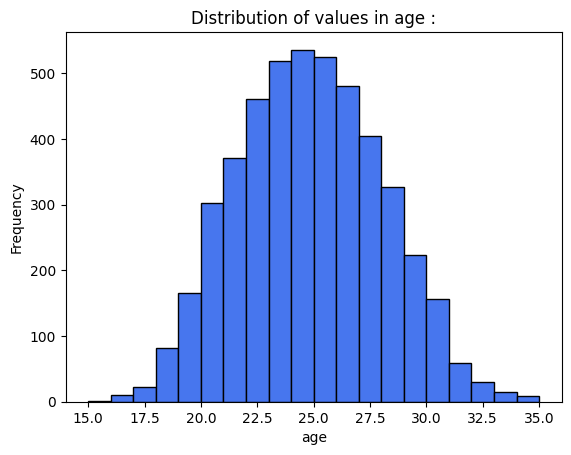

Mean value of 'age' : 24.34404255319149
Median value of 'age' : 24.0
Variance value of 'age' : 10.309932593933906
1st quartile value of 'age' : 22.0
3rd quartile value of 'age' : 27.0


In [558]:
get_hist(df, "age")

More than 25 % of the 250 most expensive football transfers recorded included players playing the 'centre forward' position, then 'centre back' at rougly 15 %, followed by 'central midfield', 'attacking midfield' and 'defensive midfield' at approx 10  %, 9% and 9% respectively. Other positions see a significant dropoff. 'forward', 'defender', 'sweeper' and 'midfielder' see little to no presence in the most exclusive 250. 

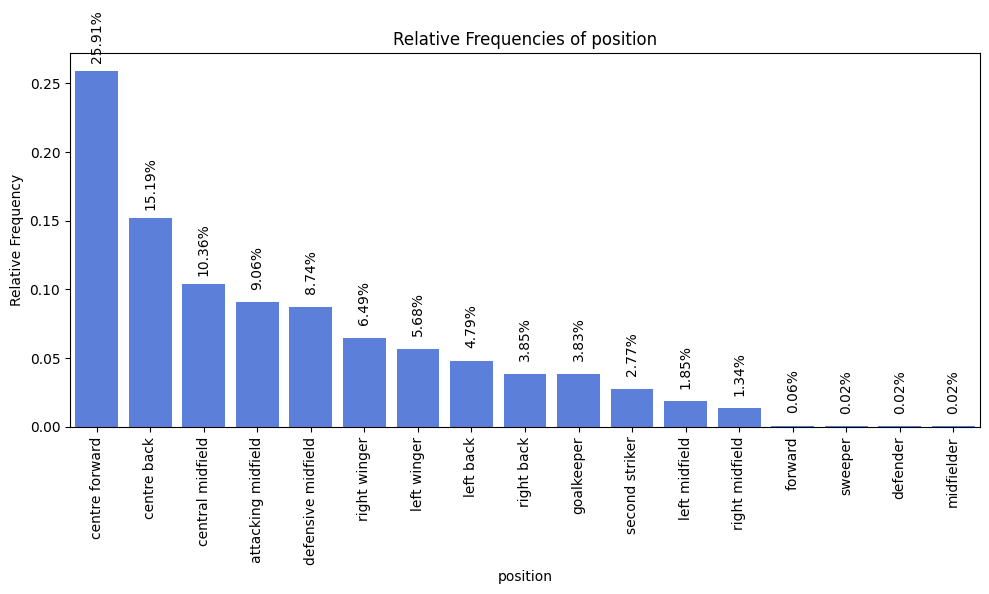

In [559]:
get_relative_freq_categorical(df,"position")

As there is more than plenty of teams and leagues, let's have a look at our added variable country. Analyzing this could give us more comprehensive look into what country's market is the best for high-profile transfers and could be a good intermediate step between analyzing leagues as it could lead us into countries with high amount of expensive transfers.

Looking at the relative frequency plot of new_country in the dataset of transfers, which symbolises the country where the player's new team is based in, we can see that England takes over with 28.70 %, followed by Italy with 16.36 %, Spain at 11.28 %, Germany and France at 9.11 % and 8.55 % respectively. After those leagues, it is only Russia with 5.04 % that clings over 5 %. This can be interpreted as such: In 28.7 % cases from the top 250 most expensive football buyouts from each year ranging from 2000-2018, the team pourchasing the player was based in England. 
This gives us an insight into how strong of a football market England is and how their teams do not fear to go to extensive lengths when purchasing new additions to their teams.


The next plot shows us the evolution on the market over time - at least for the market represented by our limited dataset. I decided to plot the top 6 who all had more than 5% share on the global market. England dominates high-end transfers for all years, the only year it just barely wasn't the top1 market for the most expensive players was 2018, when Italy, with its steady rise from  2014 came in first. In this plot we can also see the decline in high-level purchases by Russian teams, possibly corellating with the sanctions imposed by the EU and USA because of Russia's unlawful 2014 annexation of Ukrainian Crimea. 

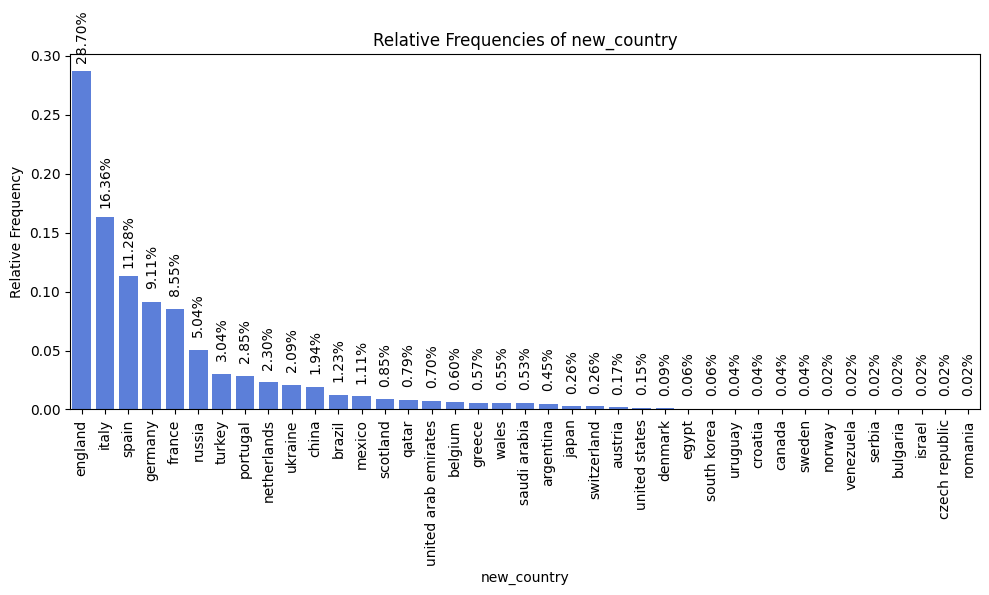

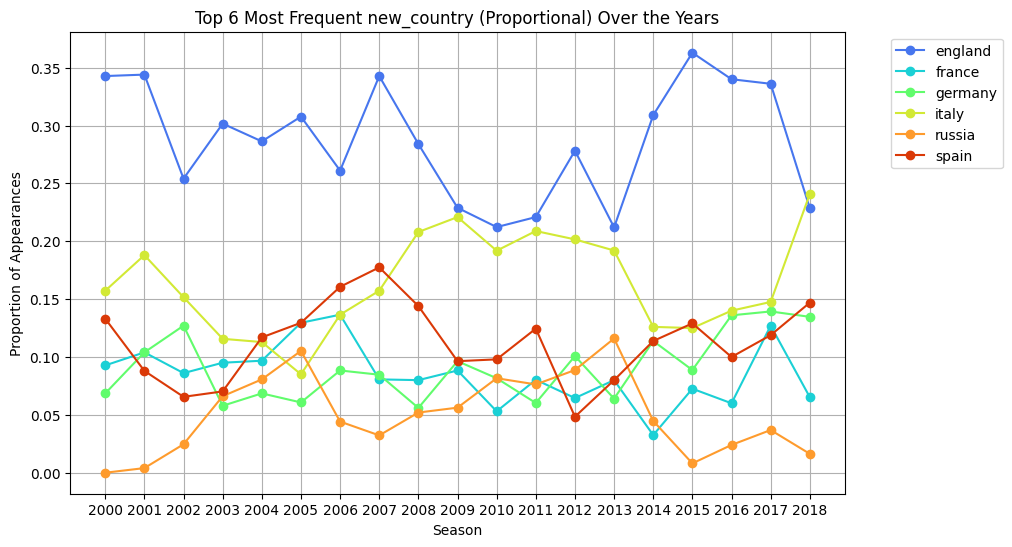

In [560]:
get_relative_freq_categorical(df, "new_country")
plot_popular_destinations("new_country", 6)

While inpecting the relative frequencies of countries in the original_country column, we can see that England tops this chart as well, albeit with slightly less dominance.
Interpreting this plot could be tricky, as one could easily interpret this plot as being the country from which players leave the most. This is not the case. This plot only shows us the home country of most of the teams who agreed to sell their players to another team for a sum that is in top 250 in given year. In this category, Brazil has replaced Russia as the last country above 5 %. This means that while Brazil teams are able to produce top-class expensive players, they are most often than not headed outside Brazil.

In this plot we see a lot more variety in the countries, as talent playing in the 'lesser' countries, when it comes to football culture, tends to go to markets which are able to pay their expensive buyouts. 

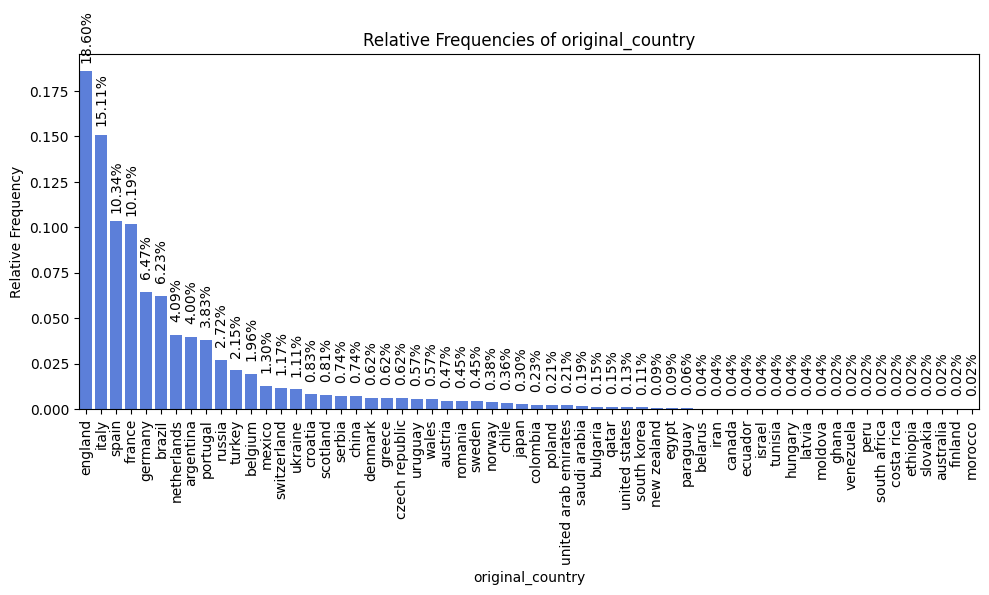

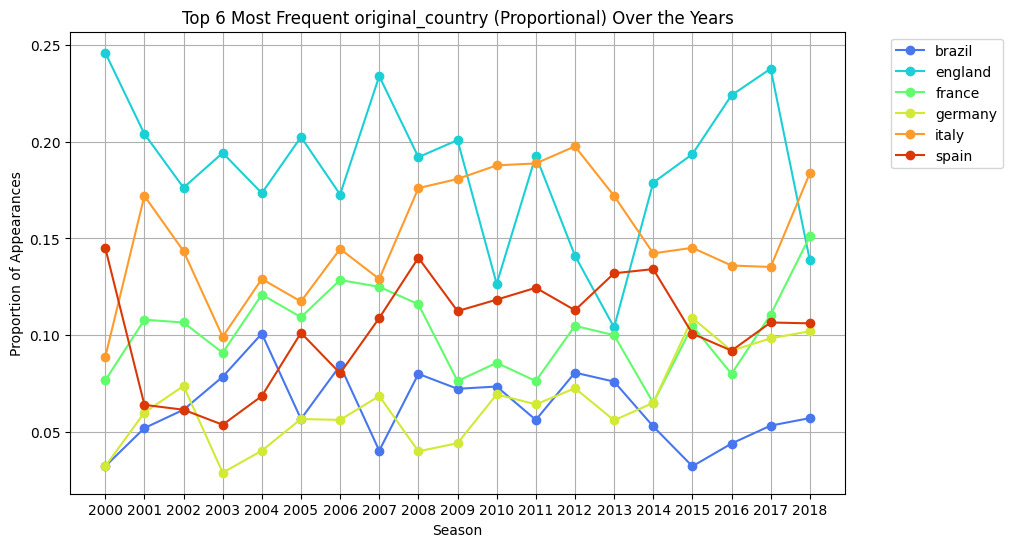

In [561]:
get_relative_freq_categorical(df, "original_country")
plot_popular_destinations("original_country", 6)

Relative frequencies of new_league are looking similarly to new_country analysis from before, but show respective leagues. The chart is once again dominated by the English - the premier league teams account for 26.72 % of the top 250 purchases from the years 2000-2018.

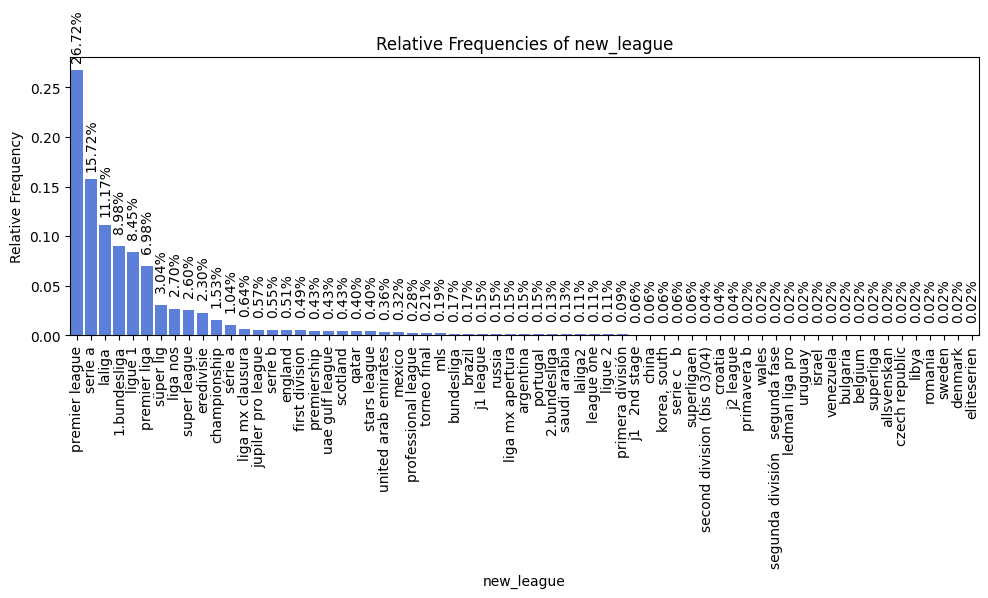

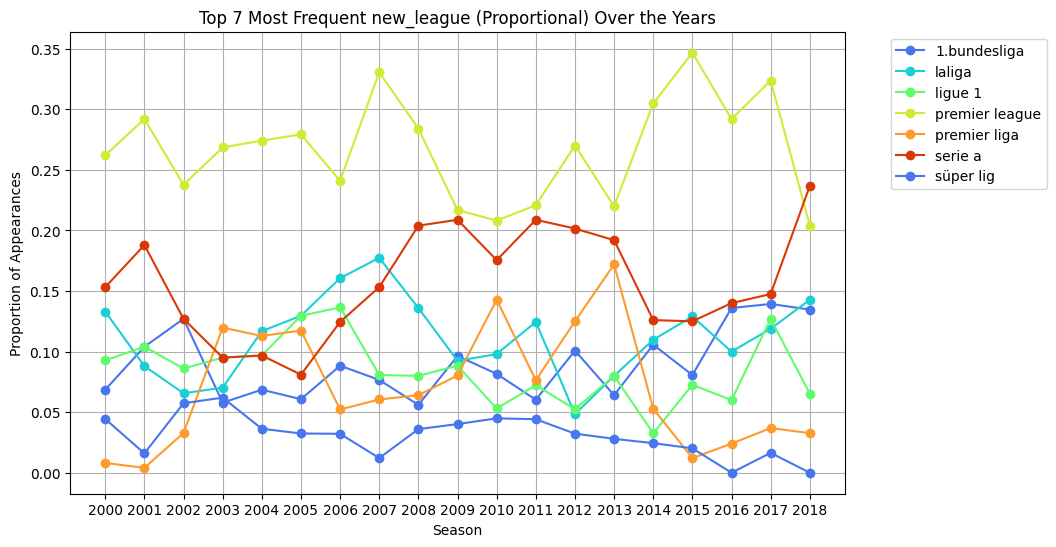

In [562]:
get_relative_freq_categorical(df, "new_league")
plot_popular_destinations("new_league", 7)

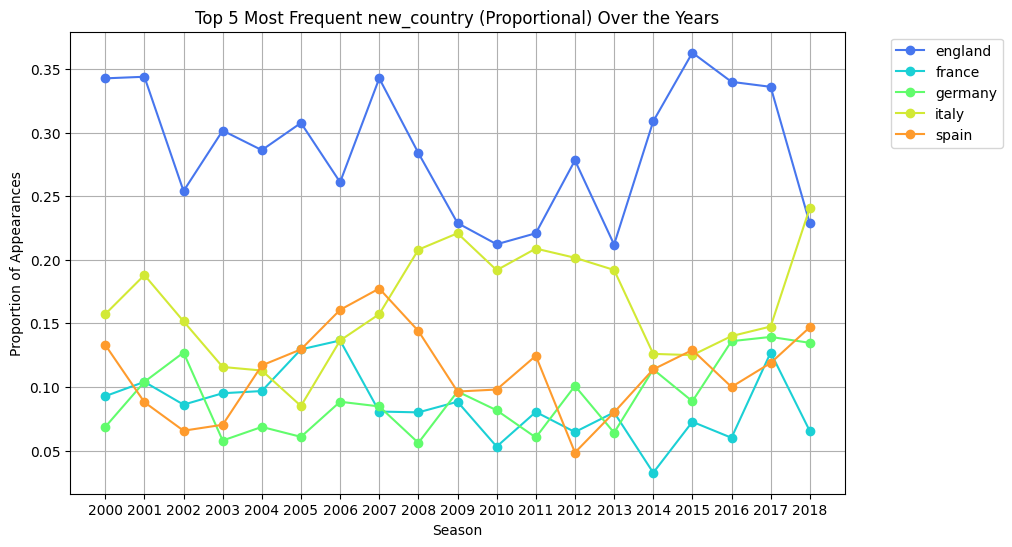

In [563]:
plot_popular_destinations("new_country", 5)

Summary DataFrame:
                              Position  Median      Mean  Support
position                                                         
left winger                left winger  8200.0  12904.64      267
right winger              right winger  7500.0  11930.36      305
central midfield      central midfield  7000.0  10096.24      487
attacking midfield  attacking midfield  6950.0   9824.18      426
defensive midfield  defensive midfield  6900.0   8992.02      411
centre forward          centre forward  6800.0   9590.27     1218
centre back                centre back  6000.0   8448.59      714
second striker          second striker  6000.0   8790.15      130
right back                  right back  5900.0   8254.31      181
left back                    left back  5500.0   7718.93      225
goalkeeper                  goalkeeper  5500.0   7622.67      180
left midfield            left midfield  4700.0   6717.13       87
right midfield          right midfield  4500.0   7404.13 

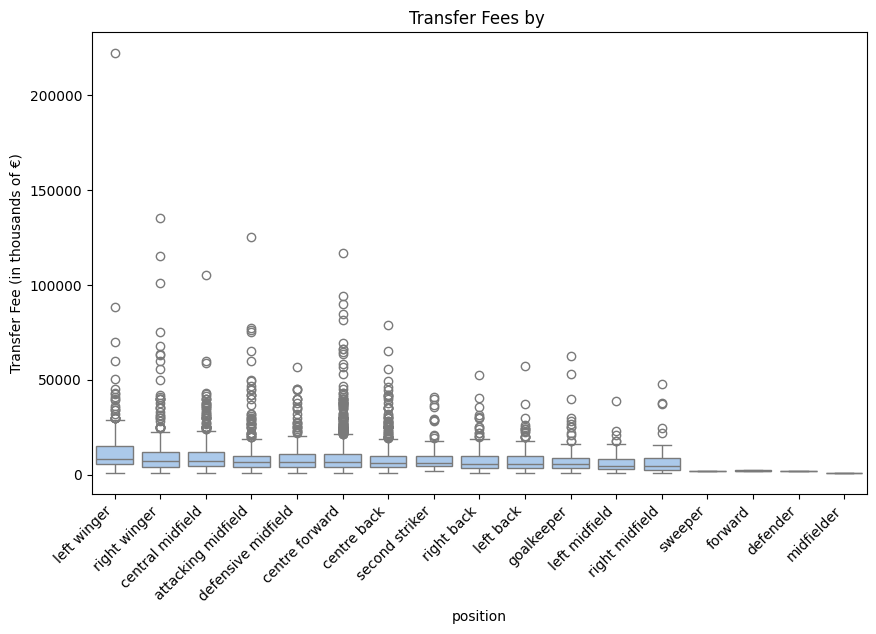

In [586]:
median_price_per_player(df, "position")

Summary DataFrame:
                                  Position  Median      Mean  Support
new_country                                                          
wales                                wales  8925.0   9211.54       26
uruguay                            uruguay  8875.0   8875.00        2
china                                china  8500.0  11949.78       91
spain                                spain  8000.0  12658.04      530
england                            england  7570.0  11187.96     1349
canada                              canada  7350.0   7350.00        2
italy                                italy  7100.0   9928.10      769
germany                            germany  6500.0   8499.17      428
united states                united states  6360.0   6962.86        7
qatar                                qatar  6300.0   6562.16       37
france                              france  6000.0   9239.35      402
united arab emirates  united arab emirates  6000.0   6937.88       33
s

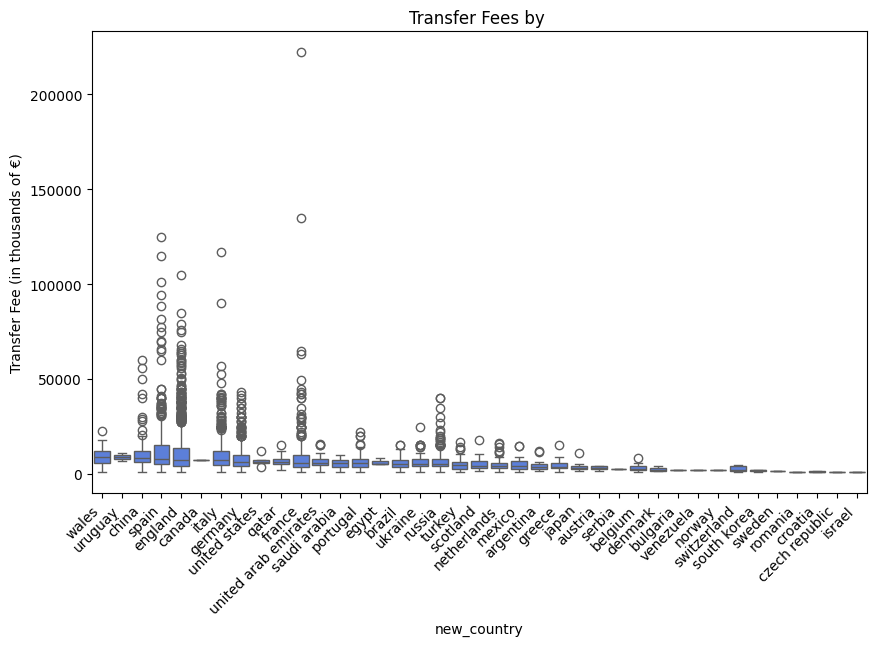

In [589]:
median_price_per_player(df, "new_country")

### Where are the most expensive players drawn? 

### 1.2 Who are the most expensive players? 

While it may be 

In [564]:
def plot_popular_destinations(dest, top_n):
    country_counts = df.groupby(['season', dest]).size().reset_index(name='counts')
    season_totals = country_counts.groupby('season')['counts'].sum().reset_index(name='total_appearances')
    
    country_counts = pd.merge(country_counts, season_totals, on='season', how='left')
    country_counts['proportion'] = country_counts['counts'] / country_counts['total_appearances']
    
    top_countries = country_counts.groupby(dest)['proportion'].sum().nlargest(top_n).index
    
    top_countries_data = country_counts[country_counts[dest].isin(top_countries)]
    
    pivot_data = top_countries_data.pivot(index='season', columns=dest, values='proportion').fillna(0)
    
    plt.figure(figsize=(10, 6))
    for country in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[country], label=country, marker='o')
    
    plt.title(f'Top {top_n} Most Frequent {dest} (Proportional) Over the Years')
    plt.xlabel('Season')
    plt.ylabel('Proportion of Appearances')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.xticks(pivot_data.index[pivot_data.index % 1 == 0].astype(int))
    
    plt.grid(True)
    plt.show()

### Finding super stars 

In [565]:
duplicate_names = df[df.duplicated('name', keep=False)]
result = df[df['name'].isin(duplicate_names['name'])]

In [566]:
result['name'].value_counts()

name
alex                   8
peter crouch           7
fernando               7
adriano                6
carlos tévez           6
                      ..
diomansy kamara        2
james collins          2
joaquín                2
sergio agüero          2
giangiacomo magnani    2
Name: count, Length: 1082, dtype: int64

In [567]:
result[result["name"] == 'fernando']

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee,new_country,original_country
969,fernando,centre back,23,flamengo,brazil,1860 munich,1.bundesliga,2003,2441.445754,1200.0,germany,brazil
2859,fernando,defensive midfield,30,al shabab,ligue 1,shabab,professional league,2011,3000.000000,6000.0,saudi arabia,saudi arabia
3292,fernando,defensive midfield,21,grêmio,série a,shakhtar d.,premier liga,2013,10000.000000,11000.0,ukraine,brazil
3509,fernando,defensive midfield,26,fc porto,liga nos,man city,premier league,2014,17500.000000,15000.0,england,portugal
3876,fernando,defensive midfield,23,shakhtar d.,premier liga,sampdoria,serie a,2015,9000.000000,8000.0,italy,ukraine
4074,fernando,defensive midfield,24,sampdoria,serie a,spartak moscow,premier liga,2016,11000.000000,12500.0,russia,italy
4662,fernando,left winger,19,palmeiras,série a,shakhtar d.,premier liga,2018,5228.177836,5500.0,ukraine,brazil


In [568]:
df = df.sort_values(by=['name', 'age'])
df['transfer_fee_diff'] = df.groupby('name')['transfer_fee'].diff()
result = df[df['transfer_fee_diff'] >= 0]
result = result.drop(columns=['transfer_fee_diff'])

In [569]:
result

,name,position,age,original_team,original_league,new_team,new_league,season,estimated_value,transfer_fee,new_country,original_country
1749,abdul kader keita,right winger,25,losc lille,ligue 1,olympique lyon,ligue 1,2007,18000.000000,16800.0,france,france
2541,abdul kader keita,right winger,28,galatasaray,süper lig,al sadd,qatar,2010,10000.000000,8150.0,qatar,turkey
3010,adam johnson,right winger,25,man city,premier league,sunderland,premier league,2012,10500.000000,12600.0,england,england
4561,adama diakhaby,centre forward,22,monaco,ligue 1,huddersfield,premier league,2018,5000.000000,10000.0,england,france
3785,adama traoré,central midfield,20,losc lille,ligue 1,monaco,ligue 1,2015,1250.000000,14000.0,france,france
...,...,...,...,...,...,...,...,...,...,...,...,...
2874,édgar barreto,central midfield,27,atalanta,serie a,us palermo,serie a,2011,3500.000000,5300.0,italy,italy
987,émerson,defensive midfield,28,as roma,serie a,juventus,serie a,2004,19809.915471,28000.0,italy,italy
1488,émerson,defensive midfield,30,juventus,serie b,real madrid,laliga,2006,26000.000000,16000.0,spain,italy
1753,éric abidal,left back,27,olympique lyon,ligue 1,fc barcelona,laliga,2007,13500.000000,15000.0,spain,france
